In [3]:
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import pandas as pd
import re
import emoji
import matplotlib.pyplot as plt

In [4]:
def limpiar_texto(texto):
    # Reemplazar URLs por token
    texto = re.sub(r"http\S+|www\S+", " URL ", texto)
    # Reemplazar menciones (@usuario)
    texto = re.sub(r"@\w+", " USER ", texto)   
    # Reemplazar hashtags (dejando la palabra)
    texto = re.sub(r"#(\w+)", r" HASHTAG_\1 ", texto) 
    # Reemplazar emojis (usando su significado textual)
    texto = emoji.demojize(texto, language="en")  # 😊 → :cara_sonriente:
    texto = re.sub(r":([a-zA-Z0-9_]+):", r" EMOJI_\1 ", texto)
    # Eliminar caracteres especiales innecesarios
    texto = re.sub(r"[^a-zA-ZáéíóúÁÉÍÓÚñÑ0-9_\s]", " ", texto) 
    # Pasar a minúsculas
    texto = texto.lower() 
    # Quitar espacios múltiples
    texto = re.sub(r"\s+", " ", texto).strip()
    
    return texto

In [5]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

SEED = 42

x_train, x_validation, y_train, y_validation = train_test_split(
    train_df['text'], train_df['target'], test_size=0.2, random_state=SEED
)

sbert = SentenceTransformer("all-mpnet-base-v2")

In [6]:
clean_text =  x_train.map(limpiar_texto)
X_emb = sbert.encode(clean_text.tolist(), show_progress_bar=True)

clf = LogisticRegression(max_iter=2000)
scores = cross_val_score(clf, X_emb, y_train, cv=5, scoring='f1')
scores.mean()

Batches: 100%|██████████| 191/191 [01:50<00:00,  1.73it/s]


np.float64(0.7827311708900079)

In [7]:
clf.fit(X_emb, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [8]:
clean_text_val = x_validation.map(limpiar_texto)
X_emb_val = sbert.encode(clean_text_val.tolist(), show_progress_bar=True)
y_pred = clf.predict(X_emb_val)

Batches: 100%|██████████| 48/48 [00:28<00:00,  1.70it/s]


In [9]:
accuracy_score(y_validation, y_pred)

0.8253447143795141

In [10]:
clean_text_test = test_df.text.map(limpiar_texto)
x_emb_test = sbert.encode(clean_text_test.tolist(), show_progress_bar=True)
y_pred_test = clf.predict(x_emb_test)

Batches: 100%|██████████| 102/102 [00:58<00:00,  1.74it/s]


In [11]:
sumbmission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': y_pred_test
})

sumbmission_df.to_csv("submission/logistic_regression_v2_submission.csv", index=False)

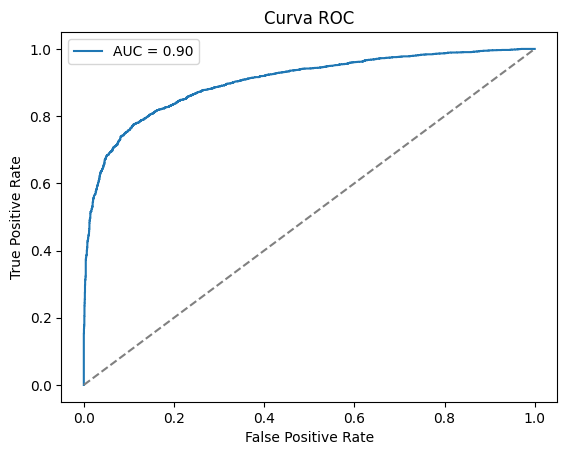

In [12]:
y_prob = clf.predict_proba(X_emb)[:, 1]
fpr, tpr, _ = roc_curve(y_train, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_train, y_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()

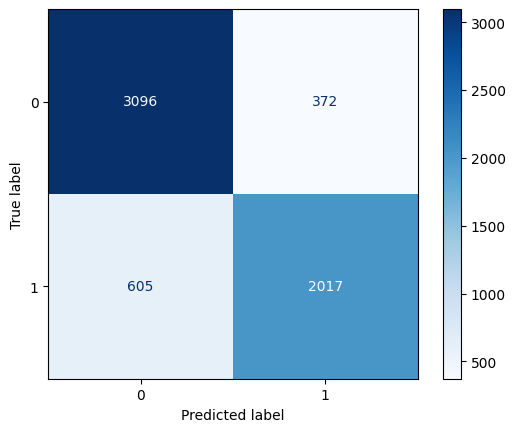

In [13]:
y_pred = clf.predict(X_emb)
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred)).plot(cmap='Blues')
plt.show()